Notebook for running regression on tree models using higher rank signatures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import Tree_Process_utils as TP
from math import ceil
from tqdm import tqdm

np.random.seed(42)

Tree processes can be initialised from data in the following format. Calling print on the tree will generate every path along with its probability.

In [2]:
data = (0, [0.5,0.5], [-1,(1,[0.5,0.5], [2,0])])
T = TP.TreeProcess(data)
print(T)
print(T.ExpSig(3, Augment = True))

p = 0.5: 
 [0, -1] 

p = 0.25: 
 [0, 1, 2] 

p = 0.25: 
 [0, 1, 0] 


Tensor series of dimension = 2 and degree = 3. Values: 
0 : [1.] 
1 : [1.5 0. ] 
2 : [[1.25 0.  ]
 [0.5  0.75]] 
3 : [[[0.75 0.  ]
  [0.25 0.5 ]]

 [[0.5  0.25]
  [0.5  0.25]]] 



In [3]:
def genPath(path = 'A', epsilon = 0.01, noise = 0.1): 
    #generates a path that doesn't move in the first time step and then moves to either N(1,mu) or N(1,-mu)
    #or a path that moves to either N(epsilon,mu) or N(epsilon,-mu) and then scales up by 1/epsilon
    eta1 = np.random.normal(0,noise,1)
    eta2 = np.random.normal(0,noise,1)
    if path=='A':
        data = (0, [0.5,0.5], [(eta1[0],[1], [eta2[0] + 1]),
                               (eta1[0],[1], [eta2[0] - 1])])
    if path=='B':
        data = (0, [0.5,0.5], [(np.sqrt(1-epsilon**2) * eta1[0] + epsilon,[1], [eta2[0] + 1]),
                               (np.sqrt(1-epsilon**2) * eta1[0] - epsilon,[1], [eta2[0] - 1])])
    return TP.TreeProcess(data)

def genBatch(paths, N=2, rank=1):
    if rank == 1:
        sigs = [t.ExpSig(N, Augment = True) for t in paths]
    if rank == 2:
        sigs = [t.ExpSigr2(N, Augment = True)[1] for t in paths]
    return np.array([s.flatten() for s in sigs])
    

The truncated rank 1 expected signature has dimension 127, and the truncated rank 2 expected signature has dimension 76.

In [4]:
dim1 = genBatch([genPath(path = 'A')], rank=2, N=3).size
dim2 = genBatch([genPath(path = 'A')], rank=1, N=6).size

print(dim1, dim2)

76 127


In [5]:
def Exper(epsilon, batchSizes):
    mu = 0
    noise = 0.1
    avgrange = 5

    S1 = []
    S2 = []

    clf = linear_model.SGDClassifier(max_iter=5000, tol=1e-5)

    for Ba in tqdm(batchSizes):
        avg1=[]
        avg2=[]
        n = ceil(Ba)

        for _ in range(avgrange):  
            pathsA = [genPath('A', epsilon, noise) for _ in range(n)]
            pathsB = [genPath('B', epsilon, noise) for _ in range(n)]

            A1 = genBatch(pathsA, rank=1, N=6) 
            B1 = genBatch(pathsB, rank=1, N=6)
            A2 = genBatch(pathsA, rank=2, N=3) 
            B2 = genBatch(pathsB, rank=2, N=3)

            X1 = np.concatenate((A1, B1), axis=0)
            X2 = np.concatenate((A2, B2), axis=0)
            y = np.concatenate((np.zeros(n),np.ones(n)))
            s1 = clf.fit(X1,y).score(X1,y)
            s2 = clf.fit(X2,y).score(X2,y)

            avg1.append(s1), avg2.append(s2)

        S1.append((np.array(avg1).mean(), np.std(np.array(avg1))))
        S2.append((np.array(avg2).mean(), np.std(np.array(avg2))))
    return S1, S2

Text(0,0.5,'Accuracy')

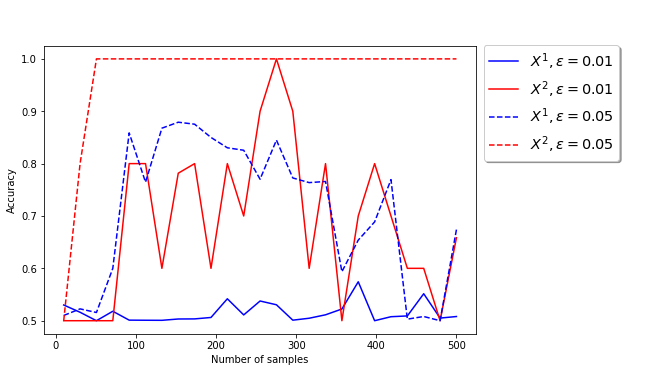

In [10]:
batchSizes = np.linspace(10, 500, num=25)

A1,A2 = Exper(0.01, batchSizes)
B1,B2 = Exper(0.05, batchSizes)

fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 1, 1])
ax.plot(batchSizes, [x[0] for x in A1], 'b', label=r'$X^1, \varepsilon = 0.01$')
ax.plot(batchSizes, [x[0] for x in A2], 'r', label=r'$X^2, \varepsilon = 0.01$')
ax.plot(batchSizes, [x[0] for x in B1], 'b--', label=r'$X^1, \varepsilon = 0.05$')
ax.plot(batchSizes, [x[0] for x in B2], 'r--', label=r'$X^2, \varepsilon = 0.05$')

legend = fig1.legend(bbox_to_anchor=(1.45, 1.16), shadow=True, fontsize='x-large')

ax.set_xlabel('Number of samples')
ax.set_ylabel('Accuracy')

In [11]:
fig1.savefig('linearclass_ber.pdf',bbox_inches="tight")

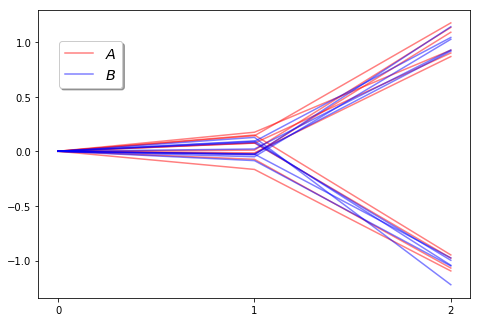

In [8]:
A = [genPath('A', 0.01, .1).sample() for _ in range(10)]
B = [genPath('B', 0.01, .1).sample() for _ in range(10)]

fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 1, 1])
ax.plot(range(3), np.transpose(A), 'r', alpha=0.5)
ax.plot(range(3), np.transpose(B), 'b', alpha=0.5)

ax.plot(0,0, 'r', alpha=0.5, label=r'$A$')
ax.plot(0,0, 'b', alpha=0.5, label=r'$B$')
ax.xaxis.set_ticks([0,1,2])

legend = fig1.legend(bbox_to_anchor=(0.3, 1), shadow=True, fontsize='x-large')

In [9]:
fig1.savefig('samples_ber.pdf',bbox_inches="tight")